
In this tutorial we will be illustrating how to set up and use (kNN) Topological PCA for Single Cell RNA-Seq Data Analysis. We will first define all the steps behind tPCA, and then illustrate its use for cell type identification by clustering and classification, as well as data visualization. Hit run all to run the entire tutorial or go cell by cell to examine the method more closely. The first several cells establish the mathematical framework behind tPCA:

1.) Describing the graph / simplicial complex structure of our data

2.) Inducing filtration

3.) Formulating Topological PCA

For reference, recall the objective function of tPCA:

$		\min_{U,Q}\|X - UQ^T\|_{2,1} + \beta\|Q\|_{2,1} + \gamma \text{Tr}(Q^T(PL)Q), \quad \text{s.t } Q^TQ = I_n$

Where $PL$ denotes the Accumulated Spectral Graph, describing the multiscale structure of our data. 

$PL := \sum_{t=1}^p\zeta_tL^t$

Where $L^t$ denotes the graph Laplacian / $\mathcal{L}_0$ combinatorial Laplacian of the $t$'th sub-complex. 

First, we define the functions which can be used to establish the graph / simplicial complex structure on which our data lies. Recall that this structure can be described by an adjacency matrix, either weighted or unweighted. 

$W_{ij} = 
    \begin{cases} 
    e^{- \| \mathbf{x}_i, \mathbf{x}_j\|^2/\eta} & \text{ if }\mathbf{x}_j \in \mathcal{N}_k(\mathbf{x}_i) \\
    0, & \text{ otherwise}. \\
    \end{cases}$

In [84]:
import numpy as np
import pandas as pd

def gaussian_kernel(dist, t):
    '''
    gaussian kernel function for weighted edges
    '''
    return np.exp(-(dist**2 / t))

def Eu_dis(x):
    """
    Calculate the distance among each raw of x
    :param x: N X D
                N: number of samples
                D: Dimension of the feature
    :return: N X N distance matrix
    """
    x = np.asarray(x)
    aa = np.sum(np.multiply(x, x), 1)
    ab = x @ x.T
    dist_mat = aa + aa.T - 2 * ab
    dist_mat[dist_mat < 0] = 0
    dist_mat = np.sqrt(dist_mat)
    dist_mat = np.maximum(dist_mat, dist_mat.T)
    dist_mat = np.asarray(dist_mat)
    return dist_mat

def cal_weighted_adj(data, n_neighbors, t):
    '''
    Calculate weighted adjacency matrix based on kNN
    For each row of X, put an edge between nodes i and j
    If nodes are among the n_neighbors nearest neighbors of each other
    according to Euclidean distance
    t is our bandwidth parameter for Gaussian Kernel
    '''
    dist = Eu_dis(data)
    n = dist.shape[0]
    gk_dist = gaussian_kernel(dist, t)
    W_L = np.zeros((n, n))
    for i in range(n):
        index_L = np.argsort(dist[i, :])[1:1 + n_neighbors] 
        len_index_L = len(index_L)
        for j in range(len_index_L):
            W_L[i, index_L[j]] = gk_dist[i, index_L[j]] #weighted edges
    W_L = np.maximum(W_L, W_L.T) #symmetrize 
    return W_L

def cal_unweighted_adj(data, n_neighbors):
    '''
    Calculate unweighted adjacency matrix based on kNN
    '''
    dist = Eu_dis(data)
    n = dist.shape[0]
    W_L = np.zeros((n, n))
    for i in range(n):
        index_L = np.argsort(dist[i, :])[1:1 + n_neighbors]
        len_index_L = len(index_L)
        for j in range(len_index_L):
            W_L[i, index_L[j]] = 1 #edges not weighted
    W_L = np.maximum(W_L, W_L.T)
    return W_L

Next, we can define our (weighted) Laplacian matrix, and induce filtration on our geometric configuration either via a distance threshold or kNN. This introduces multiscale analysis to graph Laplacian-regularized PCA. 

First, the graph Laplacian / $\mathcal{L}_0$ combinatorial Laplacian can be given by $L = D - A$, where $D$ and $A$ correspond to our degree matrix and adjacency matrix respectively. 

To induce filtration via the varying of a distance threshold, we can do the following:

$L^t = (l_{ij}^t), l_{ij}^t = 
    \begin{cases}
    0, \text{ if } l_{ij} \leq (t/p)d + l_{\text{min}} \\
    -1, \text{otherwise}.
    \end{cases}$

Where $d$ is the difference between the maximal and minimal elements of $L$. To induce filtration via a kNN framework, we can do so as follows:

$L^t = (l_{ij}^t), l_{ij}^t = 
    \begin{cases}
    -1,\text{ if } i \neq j \text{ and }\mathbf{x}_j \in \mathcal{N}_t(\mathbf{x}_i) \\
    0, \text{ otherwise}
    \end{cases}$


![Distance Based vs. kNN Induced Filtration](/Users/seancottrell/tPCA_Workshop/tPCA/knnfilt.png "Distance Based vs. kNN Induced Filtration")

In [85]:
def cal_laplace(adj):
    N = adj.shape[0]
    D = np.zeros_like(adj)
    for i in range(N):
        D[i, i] = np.sum(adj[i]) # Degree Matrix
    L = D - adj  # Laplacian
    return L

def cal_persistence(W_L, zetas, p):
    '''
        Distance based filtration
        W_L is our weighted adjacency matrix
        zetas are our connectivity weightings
        p is the number of filtrations
    '''
    # Note that zetas should contain p weights for each scale
    
    n = W_L.shape[0]
    np.fill_diagonal(W_L,0)

    L = cal_laplace(W_L)
    #print("Laplace: ", L)

    np.fill_diagonal(L, 1e8) #Make sure diagonal is excluded from maximal and minimal value consideration
    min_l = np.min(L[np.nonzero(L)]) #Establish Min Value
    #print("min: ", min_l)
    np.fill_diagonal(L, -1e8)
    max_l = np.max(L[np.nonzero(L)]) #Establish Max Value
    #print("max: ", max_l)

    d = max_l - min_l
    #print("d: ", d)

    L = cal_laplace(W_L)
    PL = np.zeros((p+1,n,n))
    for k in range(1,p+1):
        PL[k,:,:] = np.where(L < (k/p*d + min_l), 1, 0) 
        #print("Threshold for k = ", k, ": ", k/p*d + min_l)
        np.fill_diagonal(PL[k,:,:],0)
        PL[k,:,:] = cal_laplace(PL[k,:,:])
        #print(PL[k,:,:])

    P_L = np.sum(zetas[:, np.newaxis, np.newaxis] * PL, axis=0)
     
    return P_L

def cal_persistence_KNN(data, n_filtrations, zetas):
    n = data.shape[0]
    '''
    kNN filtration
    Consider n neighbors and reduce by 2 neighbors at
    each iteration of filtration down to 1 nearest neighbor
    (p filtrations)
    '''
    num_neighbors_list = range(1, n_filtrations + 1, 2)
    num_filtrations = len(num_neighbors_list)

    PL = np.zeros((num_filtrations, n, n))
    zetas = np.array(zetas)

    for idx, num_neighbors in enumerate(num_neighbors_list):
        A = cal_unweighted_adj(data, num_neighbors)
        #print('num neighbors:', num_neighbors)
        PL[idx, :, :] = cal_laplace(A)
        #print("i'th PL:", PL[idx, :, :])

    Persistent_Laplacian = np.sum(zetas[:, np.newaxis, np.newaxis] * PL, axis=0)
    return Persistent_Laplacian

Now we can define our ADMM Optimization procedure and our data embedding via (kNN) tPCA

In [86]:
def tPCA_Algorithm(xMat,laplace,beta,gamma,k,n):
    '''
    Optimization Algorithm of tPCA 
    Solve approximately via ADMM
    Need to compute optimal principal directions matrix U
    Projected Data matrix Q
    Error term matrix E = X - UQ^T
    Z matrix used to solve Q (see supplementary information)

    Inputs are data matrix X, laplacian term, scale parameters, 
    number of reduced dimensions, number of original dimensions
    '''
    # Initialize thresholds, matrices
    obj1 = 0
    obj2 = 0
    thresh = 1e-50
    V = np.eye(n) 
    vMat = np.asarray(V) # Auxillary matrix to optimize L2,1 norm
    E = np.ones((xMat.shape[0],xMat.shape[1]))
    E = np.asarray(E) # Error term X - UQ^T
    C = np.ones((xMat.shape[0],xMat.shape[1]))
    C = np.asarray(C) # Lagrangian Multiplier
    laplace = np.asarray(laplace) #Lplacian
    miu = 1 #Penalty Term
    for m in range(0, 30):
        Z = (-(miu/2) * ((E - xMat + C/miu).T @ (E - xMat + C/miu))) + beta * vMat + gamma * laplace
        # cal Q (Projected Data Matrix)
        Z_eigVals, Z_eigVects = np.linalg.eig(np.asarray(Z))
        eigValIndice = np.argsort(Z_eigVals)
        n_eigValIndice = eigValIndice[0:k]
        n_Z_eigVect = Z_eigVects[:, n_eigValIndice]
        # Optimal Q given by eigenvectors corresponding
        # to smallest k eigenvectors
        Q = np.array(n_Z_eigVect)  
        # cal V 
        q = np.linalg.norm(Q, ord=2, axis=1)
        qq = 1.0 / (q * 2)
        VV = np.diag(qq)
        vMat = np.asarray(VV)
        qMat = np.asarray(Q)
        # cal U (Principal Directions)
        U = (xMat - E - C/miu) @ qMat
        # cal P (intermediate step)
        P = xMat - U @ qMat.T - C/miu
        # cal E (Error Term)
        for i in range(E.shape[1]):
            E[:,i] = (np.max((1 - 1.0 / (miu * np.linalg.norm(P[:,i]))),0)) * P[:,i]
        # update C 
        C = C + miu * (E - xMat + U @ qMat.T)
        # update miu
        miu = 1.2 * miu

        obj1 = np.linalg.norm(qMat)
        if m > 0:
            diff = obj2 - obj1
            if diff < thresh:
                break # end iterations if error within accepted threshold
        obj2 = obj1
    return U #return transformation matrix

def tPCA_cal_projections(X_data, beta1, gamma1, k_d, zetas):
    p = len(zetas)
    n = len(X_data)  
    dist = Eu_dis(X_data)
    max_dist = np.max(dist)
    W_L = cal_weighted_adj(X_data, n_neighbors=15, t=max_dist**(2)) 
    A = W_L
    PL = cal_persistence(A, zetas, p)
    Y = tPCA_Algorithm(X_data.transpose(), PL, beta1, gamma1, k_d, n)
    return Y

def tPCA_cal_projections_KNN(X_data, beta1, gamma1, k_d, num_filtrations, zeta):
    n = len(X_data)  
    M = cal_persistence_KNN(X_data, num_filtrations, zeta)
    Y = tPCA_Algorithm(X_data.transpose(), M, beta1, gamma1, k_d, n)
    return Y

Lastly, for the sake of comparison, we can define a simple PCA model. 

In [87]:
def PCA_Algorithm(xMat,k):
    Z = -(xMat.T @ xMat)
    # Z = -(xMat.T * xMat) - (alpha * bMat.T * bMat) + beta * vMat  # (643, 643)
    Z_eigVals, Z_eigVects = np.linalg.eig(Z)
    eigValIndice = np.argsort(Z_eigVals)
    n_eigValIndice = eigValIndice[0:k]
    n_Z_eigVect = Z_eigVects[:, n_eigValIndice]
    Q = np.array(n_Z_eigVect)  # (643, 3)
    qMat = np.array(Q)  # (643, 3)
    Y = xMat @ qMat  # (20502, 3)
    return Y

def PCA_cal_projections(X_data,k_d):
    # alpha [0-1e4]
    # beta [1e-4-1e1]
    # gamma [1e-4-1e1]
    Y = PCA_Algorithm(X_data.T, k_d) #(20502, 643)
    return Y

Now we move on to downstream analysis of our scRNA-seq data. First we can perform a clustering analysis to identify cell types. As in the paper, we will reduce the dimensionality of our data such that the number of dimensions equals the number of clusters, and then perform KMeans. First, we load in and pre-process the data. For this tutorial we will be using GSE82187.

In [100]:
import os
import sys
import warnings
from sklearn.preprocessing import StandardScaler

curPath = os.path.abspath(os.getcwd())
rootPath = os.path.dirname(curPath)
sys.path.append(rootPath)

def load_X(data):
    inpath = rootPath + '/tPCA/%s/'%(data)
    X = pd.read_csv(inpath + '%s_full_X.csv'%(data))
    X = X.values[:, 1:].astype(float)
    return X

def load_y(data):
    inpath = rootPath + '/tPCA/%s/'%(data)
    y = pd.read_csv(inpath + '%s_full_labels.csv'%(data))
    y = np.array(list(y['Label'])).astype(int)
    return y

X = load_X('GSE82187')
y = load_y('GSE82187')

print('Gene Expression Shape (Genes x Cells):', X.shape)

# Log transform data
log_transform = np.vectorize(np.log)
log_X = log_transform(X+1)

# Set values below 1e-6 to 0
log_X[log_X < 1e-6] = 0

#print('X shape:', X.shape)
#print("y shape:", y.shape)

# Filter out features with low variance
row_variances = np.var(log_X, axis=1)
variance_threshold = np.percentile(row_variances, 25)  # Adjust the percentile as needed
filtered_X = log_X[row_variances >= variance_threshold]
#print('Gene filtering X shape:', filtered_X.shape)

# Filter out classes with fewer than 15 samples
filtered_X_transposed = filtered_X.T
# Get the unique classes and their counts
unique_classes, class_counts = np.unique(y, return_counts=True)
# Find the classes with less than 15 samples
classes_to_remove = unique_classes[class_counts < 15]
# Create a mask to filter the samples and labels
mask = np.isin(y, classes_to_remove, invert=True)
# Filter the dataset and labels
X_filtered = filtered_X_transposed[mask].T
y_filtered = y[mask]
# Print the filtered dataset and labels
#print("Filtered X shape:", X_filtered.shape)
#print("Filtered y shape:", y_filtered.shape)

# Normalize data
scaler = StandardScaler()
scaler.fit(X_filtered)
X_normalized = scaler.transform(X_filtered)

print('Processed Data Shape:', X_normalized.shape)


Gene Expression Shape (Genes x Cells): (18840, 705)
Processed Data Shape: (14130, 685)


In [78]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

'''
Code associated with clustering and its scores
'''

def computeClusterScore(X, y, label):
    #compute the clustering scores
    #ARI, NMI and silhouette scores
    ari = adjusted_rand_score(y, label)
    nmi = normalized_mutual_info_score(y, label)
    return ari, nmi
    

def computeKMeans(X, y, max_state = 30):
    '''
        compute k-means clustering for the reduction with 30 random instance
        input:
            X: M x N data
            y: M * 1 true labels
            max_state: number of k-means state
        return:
            LABELS: max_state * M label from k-means
            ARI: max_state * 1 ari for each instance of k-means
            NMI: max_state * 1 nmi for each instance of k-means
            Sil: max_state * 1 silhouette score for each instance of k-means
    '''
    M = X.shape[0]
    n_clusters = np.unique(y).shape[0]
    X_scaled = StandardScaler().fit_transform(X)
    LABELS = np.zeros([max_state, M])
    ARI = np.zeros(max_state); NMI = np.zeros(max_state); SIL = np.zeros(max_state)
    for state in range(max_state):
        myKM = KMeans(n_clusters = n_clusters,  n_init = 150, random_state = state)
        myKM.fit(X_scaled)
        label = myKM.labels_
        ARI[state], NMI[state] = computeClusterScore(X, y, label)
        LABELS[state, :] = label
        #print(f"KMeans Itereation: {state}")
    return ARI, NMI

k = np.unique(y_filtered).shape[0]

'''
We can either optimize zeta by determining which scales of connectivity mattter
via Grid Search
or
Set zeta to be a generic weighting like 1/t for the t'th filtration
'''

zeta = [1,1/2,1/3,1/4,1/5,1/6,2/7,1/8] 
gamma = 1e5
beta = 60

print('---------------kNN-tPCA----------------')
RpLSPCA_KNN_ari_mean = 0
RpLSPCA_KNN_nmi_mean = 0
#Principal Components
PDM = tPCA_cal_projections_KNN(X_normalized.T, beta, gamma, k, 15, zeta)
PDM = np.asarray(PDM)
TM = ((np.linalg.inv(PDM.T @ PDM)) @ (PDM.T)).T

#Projected Data Matrix
Q = (X_normalized.T @ TM)
print('Embedded Data Shape (Cells x EigenGenes):', Q.shape)

#Clustering
RpLSPCA_KNN_ari, RpLSPCA_KNN_nmi = computeKMeans(Q, y_filtered, max_state=30)
RpLSPCA_KNN_ari_mean = (RpLSPCA_KNN_ari.sum()) / 30
RpLSPCA_KNN_nmi_mean = (RpLSPCA_KNN_nmi.sum()) / 30


print('------------------PCA------------------')
#Dimensionality Reduction 
PDM = PCA_cal_projections(X_normalized.T, k)
PDM = np.asarray(PDM)
TM = ((np.linalg.inv(PDM.T @ PDM)) @ (PDM.T)).T

#Projected Data Matrix
Q = (X_normalized.T @ PDM)

#Clustering 
PCA_ari, PCA_nmi = computeKMeans(Q, y_filtered, max_state=30)
PCA_ari_mean = (PCA_ari.sum()) / 30
PCA_nmi_mean = (PCA_nmi.sum()) / 30
        
print('---------------------------------------')
print('PCA ARI:', PCA_ari_mean)
print('PCA NMI:', PCA_nmi_mean)
print('---------------------------------------')
print('tPCA ARI:', RpLSPCA_KNN_ari_mean)
print('tPCA NMI:', RpLSPCA_KNN_nmi_mean)

---------------kNN-tPCA----------------
Embedded Data Shape (Cells x EigenGenes): (685, 8)
------------------PCA------------------
---------------------------------------
PCA ARI: 0.7530069710331365
PCA NMI: 0.8975025540456776
---------------------------------------
tPCA ARI: 0.9932492572986918
tPCA NMI: 0.9853939295776895


We can then move on to performing cell type identification by classification (via kNN). We can also measure the performance of our classification as we vary the dimensionality of our embedding. We use a 60/40 split for training and testing of our classifier. To account for potential data imbalances, we perform 5-fold cross validation in our train-test split. 

In [79]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
from sklearn.neighbors import KNeighborsClassifier

warnings.filterwarnings("ignore")

zeta = [0,0,1,1,0,0,1,1] #optimized zeta weightings
gamma = 1000
beta = 100

knc = KNeighborsClassifier(n_neighbors=1)

accuracylist = []
precisionlist = []
recalllist = []
f1list = []


print('----------------kNN-tPCA-----------------')
    
for k in [1,10,20,30,40,50,60,70,80,90,100]:
    print('Embedding Dimensions = ', k)
    accuracy = 0
    precision = 0
    recall = 0
    f1 = 0
    for per in range(1, 6):
        #Principal Components
        x_train, x_test, y_train, y_test = train_test_split(X_normalized.T, y_filtered.T, test_size=int(round(X_normalized.shape[1]*0.4)), random_state=per)
        PDM = tPCA_cal_projections_KNN(x_train, beta, gamma, k, 15, zeta)
        PDM = np.asarray(PDM)
        TM = ((np.linalg.inv(PDM.T @ PDM)) @ (PDM.T)).T

        #Projected Data Matrix
        Q_train = (np.asarray(x_train) @ TM)
        Q_test = (np.asarray(x_test) @ TM)

        #Classification
        knc.fit(np.real(Q_train), y_train)
        y_predict = knc.predict(np.real(Q_test))
        
        #K-Fold Metrics
        accuracy += accuracy_score(y_test, y_predict)
        precision += precision_score(y_test, y_predict, average='macro')
        recall += recall_score(y_test, y_predict, average='macro')
        f1 += f1_score(y_test, y_predict, average='macro')
    accuracylist.append(accuracy / 5)
    precisionlist.append(precision / 5)
    recalllist.append(recall / 5)
    f1list.append(f1 / 5)

print('-------------------PCA-------------------')
accuracylist2 = []
precisionlist2 = []
recalllist2 = []
f1list2 = []
for k in [1,10,20,30,40,50,60,70,80,90,100]:
    accuracy = 0
    precision = 0
    recall = 0
    f1 = 0
    #print('k = ', k)
    for per in range(1, 6):
        #Principal Components
        x_train, x_test, y_train, y_test = train_test_split(X_normalized.T, y_filtered.T, test_size=int(round(X_normalized.shape[1]*0.4)), random_state=per)
        PDM = PCA_cal_projections(x_train, k)
        PDM = np.asarray(PDM)
        TM = ((np.linalg.inv(PDM.T @ PDM)) @ (PDM.T)).T

        #Projected Data Matrix
        Q_train = (np.asarray(x_train) @ TM)
        Q_test = (np.asarray(x_test) @ TM)

        #Classification
        knc.fit(np.real(Q_train), y_train)
        y_predict = knc.predict(np.real(Q_test))

        #K-Fold Metrics
        accuracy += accuracy_score(y_test, y_predict)
        precision += precision_score(y_test, y_predict, average='macro')
        recall += recall_score(y_test, y_predict, average='macro')
        f1 += f1_score(y_test, y_predict, average='macro')
    accuracylist2.append(accuracy / 5)
    precisionlist2.append(precision / 5)
    recalllist2.append(recall / 5)
    f1list2.append(f1 / 5)

print('-----------------------------------------')
print('PCA ACC:', np.mean(accuracylist2))
print('PCA REC:', np.mean(recalllist2))
print('PCA PRE:', np.mean(precisionlist2))
print('PCA F1:', np.mean(f1list2))
print('-----------------------------------------')
print('tPCA ACC:', np.mean(accuracylist))
print('tPCA REC:', np.mean(recalllist))
print('tPCA PRE:', np.mean(precisionlist))
print('tPCA F1:', np.mean(f1list))

----------------kNN-tPCA-----------------
Embedding Dimensions =  1
Embedding Dimensions =  10
Embedding Dimensions =  20
Embedding Dimensions =  30
Embedding Dimensions =  40
Embedding Dimensions =  50
Embedding Dimensions =  60
Embedding Dimensions =  70
Embedding Dimensions =  80
Embedding Dimensions =  90
Embedding Dimensions =  100
-------------------PCA-------------------
-----------------------------------------
PCA ACC: 0.7246848042468481
PCA REC: 0.5782902832738482
PCA PRE: 0.6655847112178073
PCA F1: 0.5791452150545414
-----------------------------------------
tPCA ACC: 0.954810882548109
tPCA REC: 0.9217564350018548
tPCA PRE: 0.9319485016514973
tPCA F1: 0.9255120941837535


We can then visualize the distribution of performances for ACC and F1 as we vary the dimensionality of the embedding. 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


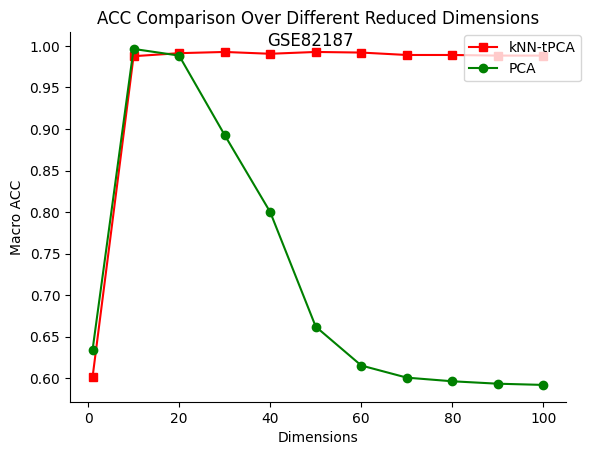

In [80]:
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
dimensions = [1,10,20,30,40,50,60,70,80,90,100]

# Add labels and a legend
plt.xlabel('Dimensions')
plt.ylabel('Macro ACC')
plt.legend()

plt.plot(dimensions, accuracylist, label='kNN-tPCA', marker='s', color='r')
plt.plot(dimensions, accuracylist2, label='PCA', marker='o', color='g')

plt.legend(loc='upper left', bbox_to_anchor=(0.78, 1.01))
# Show the plot
plt.title('ACC Comparison Over Different Reduced Dimensions')
plt.suptitle('GSE82187', y=0.88)  # Adjust the 'y' position as needed
#plt.grid(True)  # Optionally, add gridlines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


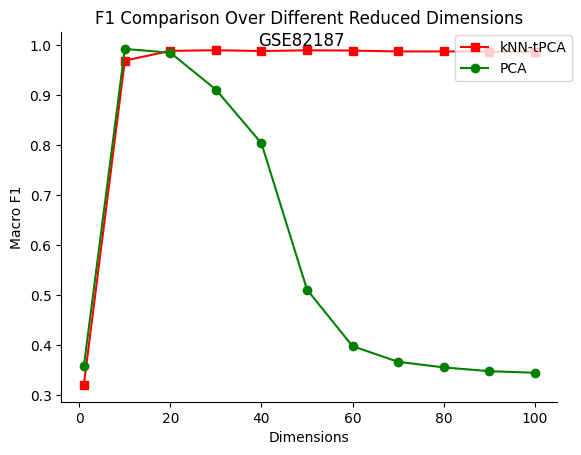

In [81]:
warnings.filterwarnings("ignore")
# Add labels and a legend
plt.xlabel('Dimensions')
plt.ylabel('Macro F1')
plt.legend()

plt.plot(dimensions, f1list, label='kNN-tPCA', marker='s', color='r')
plt.plot(dimensions, f1list2, label='PCA', marker='o', color='g')

plt.legend(loc='upper left', bbox_to_anchor=(0.78, 1.01))
# Show the plot
plt.title('F1 Comparison Over Different Reduced Dimensions')
plt.suptitle('GSE82187', y=0.88)  # Adjust the 'y' position as needed
#plt.grid(True)  # Optionally, add gridlines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

In this cell, we can visualize our projected data matrix $Q$ as a heatmap to verify that the embedding has been made sparse by the sparse regularization. You may experiment with different values of the $\beta$ and $\gamma$ parameters to examine how this influences the sparseness of our data. You may also try different values of $k$ to embed the data into different dimensions. 

Embedded Data Shape (Cells x EigenGenes): (685, 20)


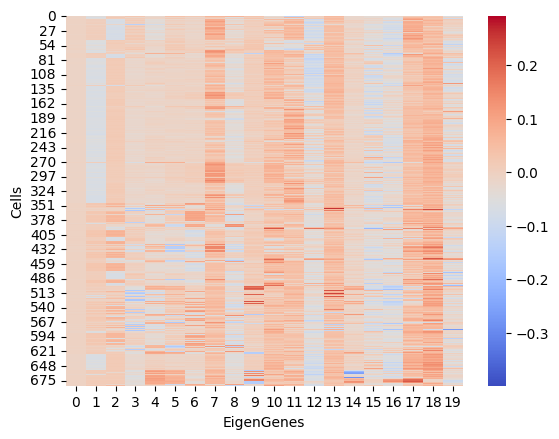

In [99]:
import seaborn as sns

k = 20
zeta = [1,1/2,1/3,1/4,1/5,1/6,2/7,1/8] 
gamma = 1e3
beta = 1e3

RpLSPCA_KNN_ari_mean = 0
RpLSPCA_KNN_nmi_mean = 0
#Principal Components
PDM = tPCA_cal_projections_KNN(X_normalized.T, beta, gamma, k, 15, zeta)
PDM = np.asarray(PDM)
TM = ((np.linalg.inv(PDM.T @ PDM)) @ (PDM.T)).T

#Projected Data Matrix
Q = (X_normalized.T @ TM)
print('Embedded Data Shape (Cells x EigenGenes):', Q.shape)

# Use seaborn to create a heatmap
ax = sns.heatmap(Q, annot=False, cmap="coolwarm", cbar=True)
ax.set_xlabel('EigenGenes')  
ax.set_ylabel('Cells')  
plt.show()


Lastly, we can compare our method's ability to effectively preprocess the data prior to visualization by tSNE and UMAP. For comparison, we can also try preprocessing via traditional PCA. We can first reduce the data to 50 dimensions via (t)PCA, and then to 2 dimensions for visualzation via tSNE and UMAP. We will also reload our datasets so as to retain the rare cell types. 

Visualizations


<Figure size 800x600 with 0 Axes>

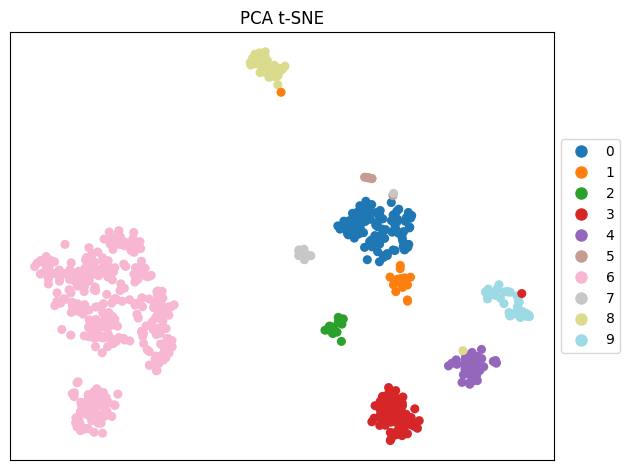

<Figure size 800x600 with 0 Axes>

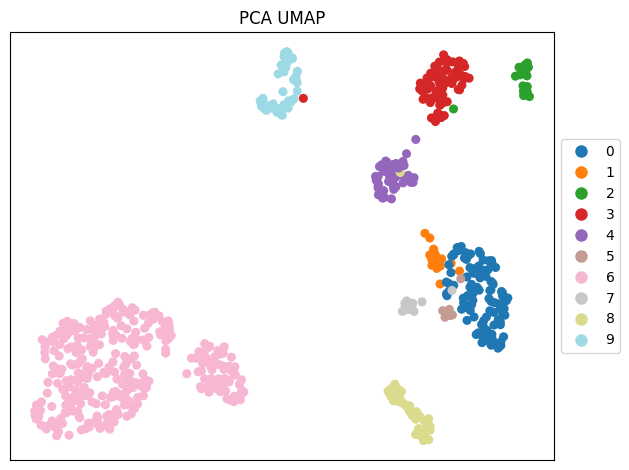

In [82]:
import matplotlib as mpl
import scanpy as sc
warnings.filterwarnings("ignore")

X = load_X('GSE82187')
y = load_y('GSE82187')

# Log transform data
log_transform = np.vectorize(np.log)
log_X = log_transform(X+1)
#print(log_X)
    
# Set values below 1e-6 to 0
log_X[log_X < 1e-6] = 0

# Filter out features with low variance
row_variances = np.var(log_X, axis=1)
variance_threshold = np.percentile(row_variances, 20)  # Adjust the percentile as needed
filtered_X = log_X[row_variances >= variance_threshold]
#print('Gene filtering X shape:', filtered_X.shape)
filtered_X = np.asarray(filtered_X)

# Normalize data
scaler = StandardScaler()
scaler.fit(filtered_X)
X_normalized = scaler.transform(filtered_X)

zetas = [1/8,1/7,1/6,1/5,1/4,1/3,1/2,1]
gamma = 1000
beta = 60

#Principal Components
PDM = tPCA_cal_projections_KNN(X_normalized.T, beta, gamma, 50, 15, zeta)
PDM = np.array(PDM)
PDM = ((np.linalg.inv(PDM.T @ PDM)) @ (PDM.T)).T

#Projected Data Matrix
Q = (X_normalized.T @ PDM)

def visualize_datasets(datasets, dataset_names):
        # Assuming datasets is a list of (X, y) tuples
        for idx, (X, y) in enumerate(datasets):
            adata = sc.AnnData(X)
            adata.obs['cell_types'] = y

            # Preprocess and compute neighbors
            sc.pp.scale(adata, max_value=10)
            sc.tl.pca(adata, n_comps=50)  # PCA for preprocessing if input is X
            sc.pp.neighbors(adata)  

            # Compute t-SNE and UMAP
            sc.tl.tsne(adata)
            sc.tl.umap(adata)

            # Get unique labels
            unique_labels = np.unique(y)
    
            # Convert 'cell_types' to categorical type with the order determined by `unique_labels`
            adata.obs['cell_types'] = pd.Categorical(y, categories=unique_labels, ordered=True)

            # Define a color palette
            color_map = plt.cm.get_cmap('tab20', len(unique_labels))
            colors_for_legend = [color_map(i) for i in range(len(unique_labels))]

            # Convert RGBA colors to hex format
            colors_for_legend_hex = [mpl.colors.to_hex(color) for color in colors_for_legend]
    
            # Assign colors based on this ordering
            adata.uns['cell_types_colors'] = colors_for_legend_hex

                   

            # t-SNE 
            plt.figure(figsize=(8,6))
            sc.pl.tsne(adata, color='cell_types', title='PCA t-SNE', show=False, legend_loc='none')
            handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors_for_legend[i], markersize=10) for i in range(len(unique_labels))]
            plt.legend(handles, unique_labels, loc='center left', bbox_to_anchor=(1, 0.5))
            plt.xlabel("")
            plt.ylabel("")
            plt.tight_layout()
            # Save the figure as a PDF
            #plt.savefig(f"KNN-tsne_{dataset_names[idx]}_figure.pdf", format='pdf')
            plt.show()

            # UMAP plot
            plt.figure(figsize=(8,6))
            sc.pl.umap(adata, color='cell_types', title='PCA UMAP', show=False, legend_loc='none')
            handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors_for_legend[i], markersize=10) for i in range(len(unique_labels))]
            plt.legend(handles, unique_labels, loc='center left', bbox_to_anchor=(1, 0.5))
            plt.xlabel("")
            plt.ylabel("")
            plt.tight_layout()
            #plt.savefig(f"KNN-umap_{dataset_names[idx]}_figure.pdf", format='pdf')
            plt.show()


# Example usage
print('Visualizations')
dataset_names = ["GSE82817"]
datasets = [(X_normalized.T, y)] #When inputting X, use PCA to preprocess in visualize_datasets()
#datasets2 = [(Q.T, y)] #When inputting Q, do not perform PCA
visualize_datasets(datasets, dataset_names) #First input datasets, and then datasets2 for compariosn

Visualizations


<Figure size 800x600 with 0 Axes>

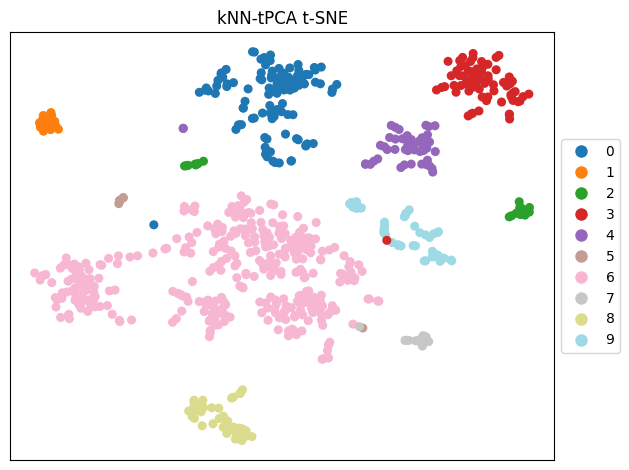

<Figure size 800x600 with 0 Axes>

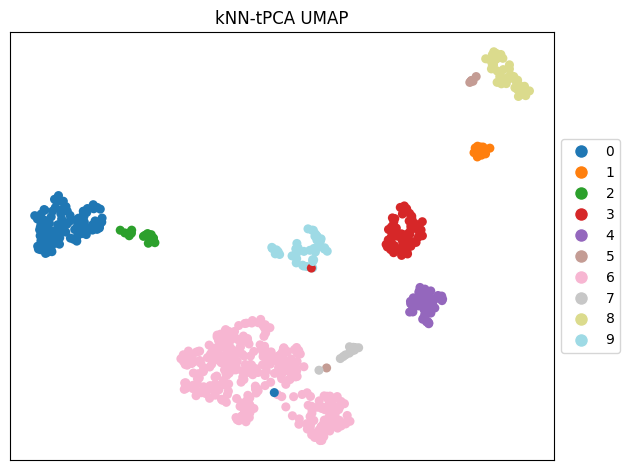

In [83]:
warnings.filterwarnings("ignore")
def visualize_datasets2(datasets, dataset_names):
        # Assuming datasets is a list of (X, y) tuples
        for idx, (X, y) in enumerate(datasets):
            adata = sc.AnnData(X)
            adata.obs['cell_types'] = y

            # Preprocess and compute neighbors
            sc.pp.scale(adata, max_value=10)
            #sc.tl.pca(adata, n_comps=50)  # PCA for preprocessing if input is X
            sc.pp.neighbors(adata)  

            # Compute t-SNE and UMAP
            sc.tl.tsne(adata)
            sc.tl.umap(adata)

            # Get unique labels
            unique_labels = np.unique(y)
    
            # Convert 'cell_types' to categorical type with the order determined by `unique_labels`
            adata.obs['cell_types'] = pd.Categorical(y, categories=unique_labels, ordered=True)

            # Define a color palette
            color_map = plt.cm.get_cmap('tab20', len(unique_labels))
            colors_for_legend = [color_map(i) for i in range(len(unique_labels))]

            # Convert RGBA colors to hex format
            colors_for_legend_hex = [mpl.colors.to_hex(color) for color in colors_for_legend]
    
            # Assign colors based on this ordering
            adata.uns['cell_types_colors'] = colors_for_legend_hex

                   

            # t-SNE 
            plt.figure(figsize=(8,6))
            sc.pl.tsne(adata, color='cell_types', title='kNN-tPCA t-SNE', show=False, legend_loc='none')
            handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors_for_legend[i], markersize=10) for i in range(len(unique_labels))]
            plt.legend(handles, unique_labels, loc='center left', bbox_to_anchor=(1, 0.5))
            plt.xlabel("")
            plt.ylabel("")
            plt.tight_layout()
            # Save the figure as a PDF
            #plt.savefig(f"KNN-tsne_{dataset_names[idx]}_figure.pdf", format='pdf')
            plt.show()

            # UMAP plot
            plt.figure(figsize=(8,6))
            sc.pl.umap(adata, color='cell_types', title='kNN-tPCA UMAP', show=False, legend_loc='none')
            handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors_for_legend[i], markersize=10) for i in range(len(unique_labels))]
            plt.legend(handles, unique_labels, loc='center left', bbox_to_anchor=(1, 0.5))
            plt.xlabel("")
            plt.ylabel("")
            plt.tight_layout()
            #plt.savefig(f"KNN-umap_{dataset_names[idx]}_figure.pdf", format='pdf')
            plt.show()


# Example usage
print('Visualizations')
dataset_names = ["GSE82817"]
#datasets = [(X.T, y)] #When inputting X, use PCA to preprocess in visualize_datasets()
datasets2 = [(Q, y)] #When inputting Q, do not perform PCA
visualize_datasets2(datasets2, dataset_names) #First input datasets, and then datasets2 for compariosn